In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER


In [2]:
import jax
import jax.numpy as jnp
from flax import nnx
from functools import partial
from jax_tqdm import scan_tqdm

from algorithms.utils import save_state, restore_state

import numpy as np

2025-03-20 13:53:48.568010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742475228.581705    7567 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742475228.585614    7567 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from ernestogym.envs_jax.single_agent.env_new_clip import MicroGridEnv as NewClipEnv
from ernestogym.envs_jax.single_agent.env import MicroGridEnv
from ernestogym.envs_jax.single_agent.env_trading_soc import MicroGridEnvSocAction

In [4]:
def my_env_creator(params, battery_type, env_type='normal'):
    if env_type == 'normal':
        env = MicroGridEnv(params, battery_type)
    elif env_type == 'soc_action':
        env = MicroGridEnvSocAction(params, battery_type)
    elif env_type == 'new_clip':
        env = NewClipEnv(params, battery_type)
    else:
        raise ValueError('Unknown env_type')
    return env, env.params

In [5]:
from ernestogym.envs_jax.single_agent.utils import parameter_generator

In [6]:
# pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
# pack_options = "ernestogym/ernesto_jax/data/battery_new/pack_init_full.yaml"
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack_init_full_cheap.yaml"

ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
# world = "ernestogym/envs_jax/single_agent/ijcnn_deg_train.yaml"
# world = "ernestogym/envs_jax/single_agent/ijcnn_deg_train_no_clip.yaml"
# world = "ernestogym/envs_jax/single_agent/ijcnn_deg_train_only_trad.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"
# world = "ernestogym/envs_jax/single_agent/ijcnn_deg_train_new_gen_data.yaml"
world = "ernestogym/envs_jax/single_agent/ijcnn_deg_train_new_gen_data_new_clip.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    # use_reward_normalization=True

)

params

{'battery': {'sign_convention': 'passive',
  'params': {'nominal_voltage': 350.4,
   'nominal_capacity': 60.0,
   'nominal_dod': 0.8,
   'nominal_lifetime': 3000,
   'v_max': 398.4,
   'v_min': 288.0,
   'temp_ambient': 298.15,
   'nominal_cost': 1500.0},
  'bounds': {'voltage': {'low': 288.0, 'high': 398.4},
   'current': {'low': -180.0, 'high': 60.0},
   'power': {'low': -71712.0, 'high': 23904.0},
   'temperature': {'low': 273.15, 'high': 323.15},
   'temp_ambient': {'low': 273.15, 'high': 323.15},
   'soc': {'low': 0.2, 'high': 1.0},
   'soh': {'low': 0.6, 'high': 1.0}},
  'init': {'voltage': 310.8,
   'current': 0.0,
   'power': 0.0,
   'temperature': 293.15,
   'temp_ambient': 293.15,
   'soc': 1.0,
   'soh': 1.0}},
 'input_var': 'current',
 'models_config': [{'type': 'electrical',
   'class_name': 'TheveninModel',
   'use_fading': False,
   'components': {'r0': {'selected_type': 'lookup',
     'scalar': 10.0,
     'lookup': {'table': 'r0_pack.csv',
      'inputs': [{'var': 'temp

In [7]:
# pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
# pack_options = "ernestogym/ernesto_jax/data/battery_new/pack_init_full.yaml"
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack_init_full_cheap.yaml"


ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
# world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test.yaml"
# world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test_no_clip.yaml"
# world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test_only_trad.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"
# world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test_new_gen_data.yaml"
world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test_new_gen_data_new_clip.yaml"

params_testing = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    # use_reward_normalization=True

)

params_testing['step']

3600

In [8]:
from algorithms.ppo import make_train, train_wrapper  # , train_for, train_for_flax
from flax.core.frozen_dict import freeze, unfreeze

In [9]:
num_envs = 4

total_timesteps = 8760 * num_envs * 200 #876000 * num_envs * 3

env_type = 'new_clip'

config = {
    "LR": 1e-3,
    'LR_MIN': 1e-5,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 8192, #2048 #10000,
    # "TOTAL_TIMESTEPS": 100000 * num_envs,
    "TOTAL_TIMESTEPS": total_timesteps,
    "UPDATE_EPOCHS": 10,
    "NUM_MINIBATCHES": 32,
    "NORMALIZE_ENV": False,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.98,
    "CLIP_EPS": 0.25,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "NET_ARCH": (64, 32, 16), #(16, 16, 16),
    "ACTIVATION": 'tanh',
    "LOGISTIC_FUNCTION_TO_ACTOR": False,
    "ENV_NAME": None,
    # "ANNEAL_LR": False,
    'LR_SCHEDULE': 'constant',
    'DEBUG': False,
    "NORMALIZE_REWARD_FOR_GAE_AND_TARGETS": False,
    "NORMALIZE_TARGETS": False,
    "NORMALIZE_ADVANTAGES": True,
    "ENV_TYPE": env_type,
    'NETWORK': 'actor_critic',
    'USE_WEIGHT_DECAY': True
}



rng = jax.random.PRNGKey(42)

env, env_params = my_env_creator(params, battery_type, env_type=env_type)
env, env_params, train_state = make_train(config, env, env_params)

env_testing, env_testing_params = my_env_creator(params_testing, battery_type, env_type=env_type)

val_rng = jax.random.PRNGKey(51)
val_num_iters = 8670*8

# out = train_jit(rng)

config = freeze(config)

norm? False
norm? False


In [10]:
print(config)

FrozenDict({
    LR: 0.001,
    LR_MIN: 1e-05,
    NUM_ENVS: 4,
    NUM_STEPS: 8192,
    TOTAL_TIMESTEPS: 7008000,
    UPDATE_EPOCHS: 10,
    NUM_MINIBATCHES: 32,
    NORMALIZE_ENV: False,
    GAMMA: 0.99,
    GAE_LAMBDA: 0.98,
    CLIP_EPS: 0.25,
    ENT_COEF: 0.01,
    VF_COEF: 0.5,
    MAX_GRAD_NORM: 0.5,
    NET_ARCH: (64, 32, 16),
    ACTIVATION: 'tanh',
    LOGISTIC_FUNCTION_TO_ACTOR: False,
    ENV_NAME: None,
    LR_SCHEDULE: 'constant',
    DEBUG: False,
    NORMALIZE_REWARD_FOR_GAE_AND_TARGETS: False,
    NORMALIZE_TARGETS: False,
    NORMALIZE_ADVANTAGES: True,
    ENV_TYPE: 'new_clip',
    NETWORK: 'actor_critic',
    USE_WEIGHT_DECAY: True,
    NUM_UPDATES: 213,
    MINIBATCH_SIZE: 1024,
    ACTION_SPACE_SIZE: 1,
    OBSERVATION_SPACE_SIZE: 10,
})


In [11]:
network, optimizer = nnx.merge(train_state.graph_def, train_state.state)

In [12]:
network

ActorCritic(
  act_layers=[Linear(
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x7b52d04d1e40>,
    dot_general=<function dot_general at 0x7b536e9ff100>,
    dtype=None,
    in_features=10,
    kernel=Param(
      value=Array(shape=(10, 64), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x7b52d04d2160>,
    out_features=64,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  ), <PjitFunction of <function tanh at 0x7b536e695d00>>, Linear(
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x7b52d054b880>,
    dot_general=<function dot_general at 0x7b536e9ff100>,
    dtype=None,
    in_features=64,
    kernel=Param(
      value=Array(shape=(64, 32), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x7b52d054bba0>,
    out_features=32,
    param_dtype=<class '

Running for 213 iterations:   0%|          | 0/213 [00:00<?, ?it/s]

curr_iter: 0
	r_tot: -2061.42431640625
	r_trad: -869.9215087890625
	r_deg: -877.75244140625
	r_clip: -313.7503967285156
	mean soc: 0.2158130407333374
	std actions: 0.03627832233905792

curr_iter: 10
	r_tot: -1850.731689453125
	r_trad: -867.9188232421875
	r_deg: -885.2181396484375
	r_clip: -97.59477233886719
	mean soc: 0.22569945454597473
	std actions: 0.032516203820705414

curr_iter: 20
	r_tot: -1859.7674560546875
	r_trad: -862.5465087890625
	r_deg: -891.229736328125
	r_clip: -105.99119567871094
	mean soc: 0.22612279653549194
	std actions: 0.05565590411424637

curr_iter: 30
	r_tot: -1860.0211181640625
	r_trad: -837.8541259765625
	r_deg: -898.40185546875
	r_clip: -123.7651138305664
	mean soc: 0.2253471165895462
	std actions: 0.08661144971847534

curr_iter: 40
	r_tot: -2276.00390625
	r_trad: -818.4700317382812
	r_deg: -1443.03173828125
	r_clip: -14.501906394958496
	mean soc: 0.8473755717277527
	std actions: 0.08832373470067978

curr_iter: 50
	r_tot: -1781.712646484375
	r_trad: -819.85754

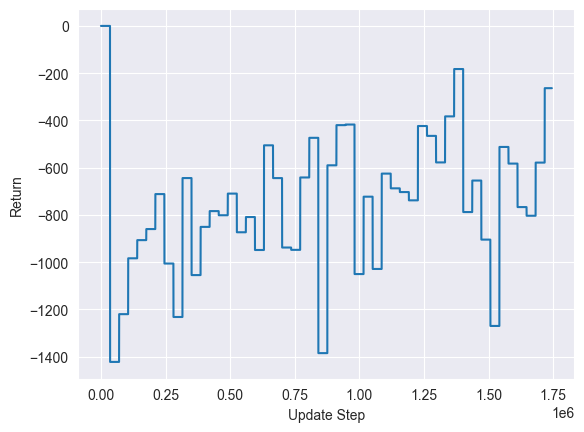

In [13]:
import time
import matplotlib.pyplot as plt
rng = jax.random.PRNGKey(42)
t0 = time.time()
out = train_wrapper(env, env_params, config, train_state, rng, validate=True, freq_val=10, val_env=env_testing, val_params=env_testing_params, val_rng=val_rng, val_num_iters=val_num_iters)

# out = train_for_flax(env, env_params, config, network, optimizer, rng)

train_state = out['runner_state'][0]

print(f"time: {time.time() - t0:.2f} s")
plt.plot(out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
plt.show()

In [14]:
out["metrics"]['r_tot'].device

CpuDevice(id=0)

In [15]:
out['val_info']['r_tot'].device

CpuDevice(id=0)

In [16]:
out2 = jax.device_put(out, device=jax.devices('cpu')[0])
out2['val_info']['r_tot'].device

CpuDevice(id=0)

In [17]:
network, optimizer = nnx.merge(train_state.graph_def, train_state.state)
network

ActorCritic(
  act_layers=[Linear(
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x7b52d04d1e40>,
    dot_general=<function dot_general at 0x7b536e9ff100>,
    dtype=None,
    in_features=10,
    kernel=Param(
      value=Array(shape=(10, 64), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x7b52d04d2160>,
    out_features=64,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  ), <PjitFunction of <function tanh at 0x7b536e695d00>>, Linear(
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x7b52d054b880>,
    dot_general=<function dot_general at 0x7b536e9ff100>,
    dtype=None,
    in_features=64,
    kernel=Param(
      value=Array(shape=(64, 32), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x7b52d054bba0>,
    out_features=32,
    param_dtype=<class '

## State saving

In [18]:
save_state(network, config, params, train_info=out['metrics'], val_info=out.get('val_info'), env_type=env_type, additional_info='total_timesteps'+str(total_timesteps)+'_init_full_'+str('full' in pack_options))

In [19]:
out

{'metrics': {'action': Array([[[[ 1.17196703e+00],
           [-3.44939053e-01],
           [-8.05101216e-01],
           [-5.66172659e-01]],
  
          [[-1.23013949e+00],
           [ 4.71281946e-01],
           [-2.00374722e-01],
           [ 2.94164300e-01]],
  
          [[-1.80924341e-01],
           [-1.62283443e-02],
           [-1.24465895e+00],
           [-2.05689117e-01]],
  
          ...,
  
          [[-9.89345312e-02],
           [ 9.48869467e-01],
           [ 6.29882991e-01],
           [-3.23800705e-02]],
  
          [[ 7.62102425e-01],
           [ 6.31914794e-01],
           [-7.75131643e-01],
           [ 1.88455260e+00]],
  
          [[ 5.65267086e-01],
           [ 1.58242559e+00],
           [ 4.60903108e-01],
           [ 7.20355213e-01]]],
  
  
         [[[ 9.63688552e-01],
           [ 1.52132487e+00],
           [-6.90419316e-01],
           [-2.60074282e+00]],
  
          [[-1.36686742e+00],
           [-1.83837032e+00],
           [-1.82774985e+00],

In [20]:
r_trad = out['metrics']['weig_reward']['r_trad'].mean(-1).reshape(-1)
r_trad_cum = np.cumsum(r_trad)
r_trad.shape

(1744896,)

In [21]:
acts = out['metrics']['action'].flatten()
acts.min(), acts.max(), acts.mean()

(Array(-4.451389, dtype=float32),
 Array(4.3604374, dtype=float32),
 Array(-0.02423189, dtype=float32))

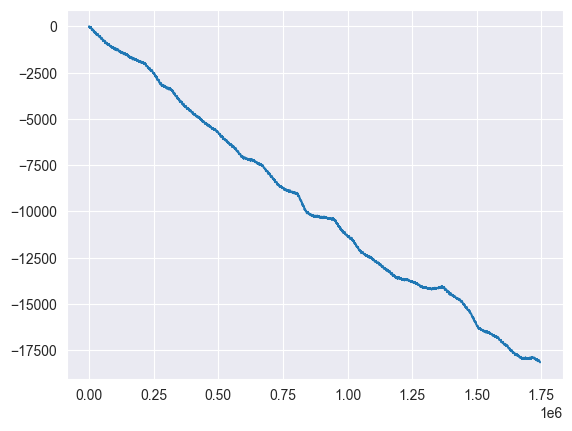

In [22]:
plt.plot(r_trad_cum)

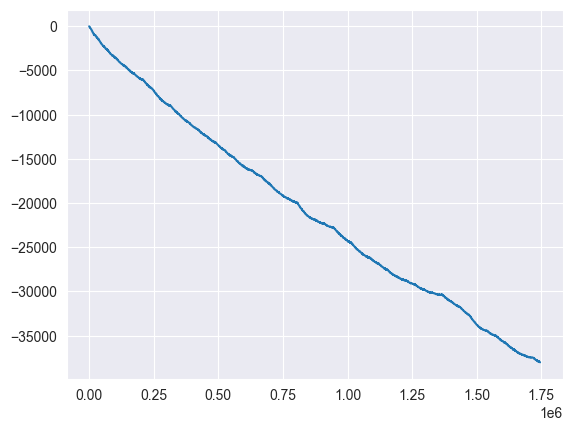

In [23]:
r_tot_cum = np.cumsum(out['metrics']['r_tot'].mean(-1).reshape(-1))
plt.plot(r_tot_cum)

# Testing

In [24]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
# pack_options = "ernestogym/ernesto_jax/data/battery_new/pack_init_full.yaml"

ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test_only_trad.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

params['step']

3600

In [25]:
@partial(jax.jit, static_argnums=(0, 2, 3))
def test(env: MicroGridEnv, env_params, network, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, env_params)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv, env_state, rng = runner_state

        pi, _ = network(obsv)

        #deterministic action
        action = pi.mode()

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(_rng, env_state, action, env_params)

        runner_state = (obsv, env_state, rng)
        return runner_state, (info, action)

    runner_state = (obsv, env_state, rng)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [26]:
env, env_params = my_env_creator(params, battery_type, env_type=env_type)
env_params = env.eval(env_params)

norm? True


In [27]:
num_iter = 8760 * 8
info, actions = test(env, env_params, network, num_iter, jax.random.PRNGKey(51))


Running for 70,080 iterations:   0%|          | 0/70080 [00:00<?, ?it/s]

In [28]:
jax.tree.map(lambda val: val.shape, info)

{'buy_price': (70080,),
 'demand': (70080,),
 'generation': (70080,),
 'i_to_apply': (70080,),
 'norm_reward': {'r_clipping': (70080,),
  'r_deg': (70080,),
  'r_op': (70080,),
  'r_trad': (70080,)},
 'p': (70080,),
 'pure_reward': {'r_clipping': (70080,),
  'r_deg': (70080,),
  'r_op': (70080,),
  'r_trad': (70080,)},
 'r_tot': (70080,),
 'sell_price': (70080,),
 'soc': (70080,),
 'soh': (70080,),
 'weig_reward': {'r_clipping': (70080,),
  'r_deg': (70080,),
  'r_op': (70080,),
  'r_trad': (70080,)}}

In [29]:
actions.max(), actions.min(), actions.mean()

(Array(0.11929994, dtype=float32),
 Array(-0.1320548, dtype=float32),
 Array(-0.01611491, dtype=float32))

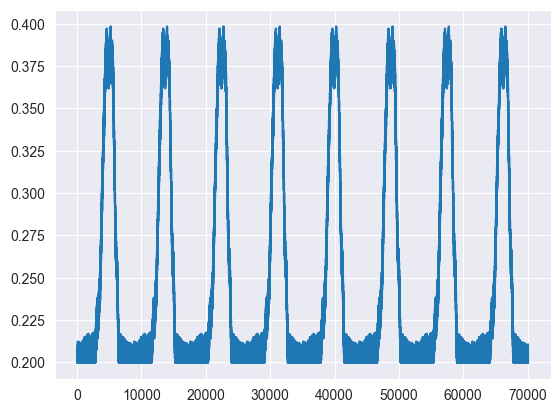

In [30]:
plt.plot(info['soc'])

In [31]:
reward_type = 'weig_reward'

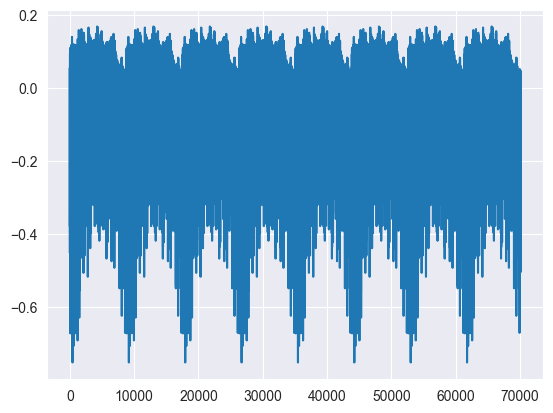

In [32]:
plt.plot(info[reward_type]['r_trad'])

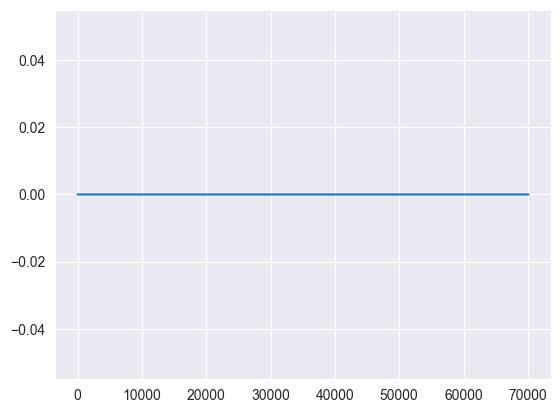

In [33]:
plt.plot(info[reward_type]['r_clipping'])

In [34]:
info['pure_reward']['r_clipping'].mean(), info['weig_reward']['r_clipping'].mean()

(Array(-0.00146368, dtype=float32), Array(-0., dtype=float32))

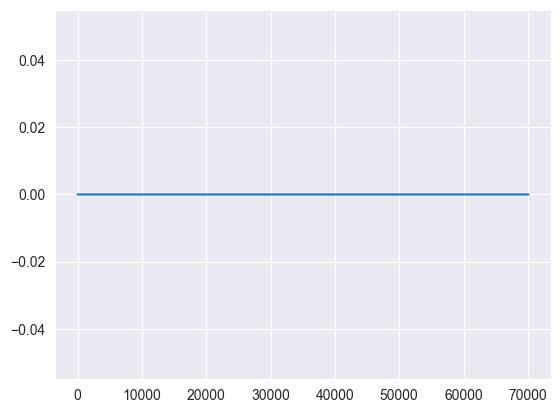

In [35]:
plt.plot(info[reward_type]['r_deg'])

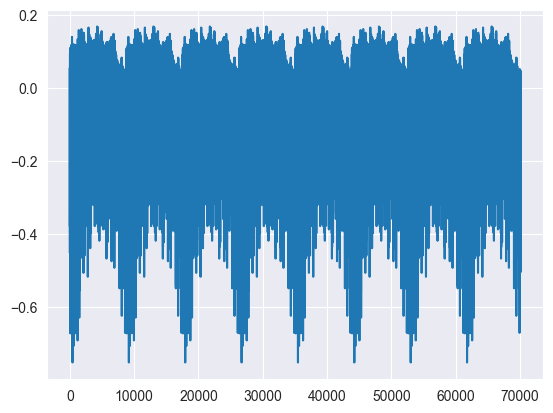

In [36]:
plt.plot(info['r_tot'])

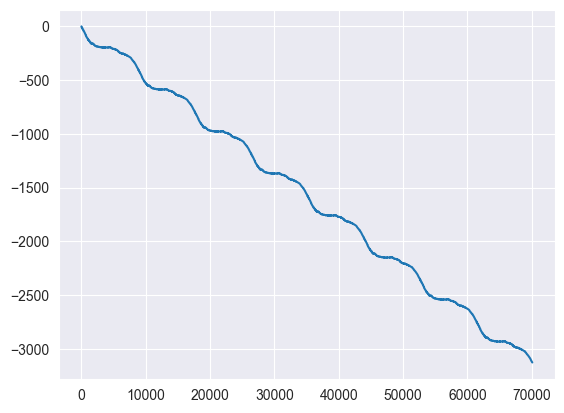

In [37]:
plt.plot(np.cumsum(info[reward_type]['r_trad']))

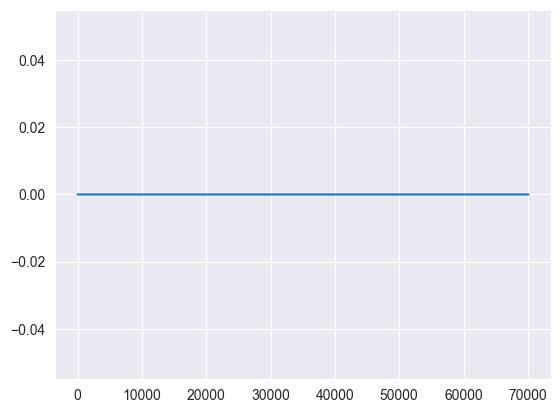

In [38]:
plt.plot(np.cumsum(info[reward_type]['r_clipping']))

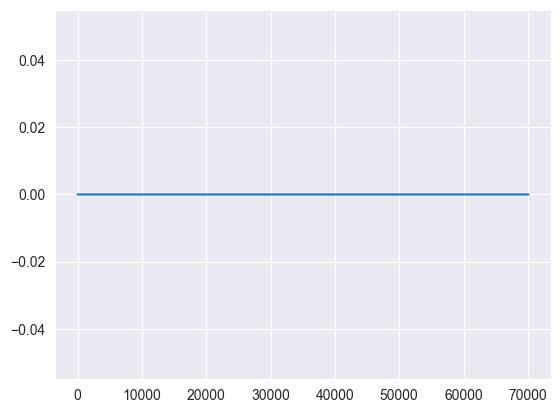

In [39]:
plt.plot(np.cumsum(info[reward_type]['r_deg']))

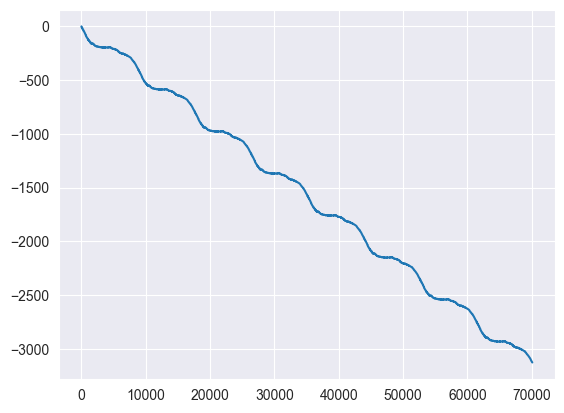

In [40]:
plt.plot(np.cumsum(info['r_tot']))

In [41]:
print(info['soc'])

[0.2 0.2 0.2 ... 0.2 0.2 0.2]


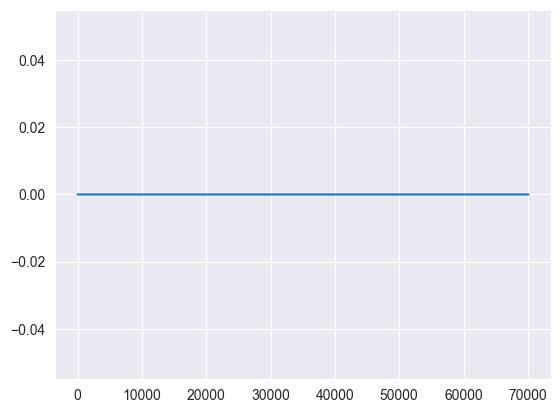

In [42]:
plt.plot(np.cumsum(info[reward_type]['r_deg']))

In [43]:
print(info['soc'])

[0.2 0.2 0.2 ... 0.2 0.2 0.2]
